## MCMC that generates 5− or 6− letter ’name-like’ strings.

This is a simple MCMC that generates 5− or 6− letter ’name-like’ strings. The model is based on the frequency of letters in the English language. The model is trained on a list of names, and then it generates new names based on the learned frequencies. The model uses a Markov chain to generate new names. The Markov chain is a probabilistic model that generates a sequence of events based on the probabilities of the events. In this case, the events are the letters in the names, and the probabilities are based on the frequencies of the letters in the English language.

The model will be fed its output as input recursively to simulate **model collapse**. 

**Model collapse:** A phenomenon where machine learning models gradually degrade due to errors coming from uncurated training on the outputs of another model, including prior versions of itself. Such outputs are known as synthetic data

In [1]:
import numpy as np
import pandas as pd
import random

trigram = pd.read_csv("Data/names_trigrams.csv")

In [2]:
##################
#Helper Functions#
##################

def generate_random_string(n):
    alphabet = list(map(chr, range(ord('a'), ord('z') + 1)))
    random_string = []
    for i in range(n):
        random_string.append(alphabet[random.randint(0,len(alphabet)-1)])
    return ''.join(random_string)


def score_string(s, trigram_df):
    trigram_dict = dict(zip(trigram_df['Unnamed: 0'], trigram_df['Probability']))
    smoothing_factor = 1e-6
    score = 0
    trigrams = [s[i:i+3] for i in range(len(s) - 2)]
    for tri in trigrams:
        if tri in trigram_dict:
            score += np.log(trigram_dict[tri])
        else:
            score += np.log(smoothing_factor)
    
    return score


def modify_string(s):
    alphabet = list(map(chr, range(ord('a'), ord('z') + 1)))
    s_list = list(s)
    id_change = random.randint(0,len(s)-1)
    s_list[id_change] = alphabet[random.randint(0, len(alphabet)-1)]
    s = ''.join(s_list)

    return s
    
######
#MCMC#
######

total_trigrams = trigram['Count'].sum()
trigram['Probability'] = trigram['Count'] / total_trigrams

current_string = generate_random_string(5)  # or 6
current_score = score_string(current_string, trigram)
temperature = 1

# MCMC process
n_runs = 15
n_iters = 5000
for run in range(n_runs):
    for iter in range(n_iters):
        new_string = modify_string(current_string)
        new_score = score_string(new_string, trigram)
        if new_score > current_score:
            current_string = new_string
            current_score = new_score
        else:
            if random.random() < np.exp((new_score - current_score) / temperature):
                current_string = new_string
                current_score = new_score

    print(current_string, current_score)


chani -16.18900645945216
narma -21.873160495166644
karia -17.256483537535846
eshar -15.376612177396153
aritt -18.62997990233061
jeric -17.81196748862492
risha -14.786451785210957
jerry -19.802466114995966
shana -14.694118964026973
adist -21.19211062844319
reman -20.899280985324353
kitav -21.169972644744856
shann -14.275557316998963
uchal -21.19786030823176
shass -18.867120920633383


In [9]:
"""
Recursive MCMC name-generator to study model collapse.
------------------------------------------------------
* Starts from a real trigram table (names_trigrams.csv)
* Generates N synthetic names with an MCMC sampler
* Re-estimates the trigram distribution from the synthetic data
  (optionally keeps the original real data as well – see flag)
* Repeats G generations, saving artefacts at each step.
"""

import numpy as np
import pandas as pd
import random
import json
from pathlib import Path
from collections import Counter
from scipy.stats import entropy

# ---------- USER-TUNABLE HYPERPARAMETERS ----------
GENS                 = 9        # recursion depth
N_NAMES_PER_GEN      = 10_000   # synthetic examples per generation
N_ITERS_PER_NAME     = 1_000    # MCMC steps for one name
NAME_LENGTH_OPTIONS  = [5, 6]   # allowed lengths
TEMPERATURE          = 1.0      # Metropolis-Hastings temp
ACCUMULATE_REAL      = False    # True -> real+synthetic, False -> replace
OUT_DIR              = Path("collapse_runs")
RNG_SEED             = 101
# ---------------------------------------------------

random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
OUT_DIR.mkdir(exist_ok=True, parents=True)


########################
# 1.  Utility helpers  #
########################
ALPHABET = [chr(i) for i in range(ord('a'), ord('z') + 1)]

def modify_string(s):
    idx = random.randrange(len(s))
    s_list = list(s)
    s_list[idx] = random.choice(ALPHABET)
    return ''.join(s_list)

def score_string(s, trigram_probs, smoothing=1e-6):
    tris = [s[i:i+3] for i in range(len(s)-2)]
    return sum(np.log(trigram_probs.get(t, smoothing)) for t in tris)

def generate_one_name(trigram_probs, length):
    current = ''.join(random.choice(ALPHABET) for _ in range(length))
    current_score = score_string(current, trigram_probs)
    for _ in range(N_ITERS_PER_NAME):
        proposal = modify_string(current)
        prop_score = score_string(proposal, trigram_probs)
        if prop_score > current_score or random.random() < np.exp((prop_score-current_score)/TEMPERATURE):
            current, current_score = proposal, prop_score
    return current

def produce_names(trigram_df):
    probs = dict(zip(trigram_df['trigram'], trigram_df['prob']))
    names = [
        generate_one_name(probs, random.choice(NAME_LENGTH_OPTIONS))
        for _ in range(N_NAMES_PER_GEN)
    ]
    return names

def names_to_trigram_df(names):
    tris = []
    for w in names:
        tris.extend(w[i:i+3] for i in range(len(w)-2))
    counts = Counter(tris)
    df = pd.DataFrame(counts.items(), columns=['trigram', 'count'])
    df['prob'] = df['count'] / df['count'].sum()
    return df.sort_values('trigram').reset_index(drop=True)

def kl_divergence(p_df, q_df):
    # Align supports
    merged = p_df.merge(q_df, on='trigram', how='outer', suffixes=('_p', '_q')).fillna(1e-12)
    return entropy(merged['prob_p'], merged['prob_q'])  


########################
# 2.  Initial loading  #
########################
orig_tri = pd.read_csv("Data/names_trigrams.csv")
orig_tri = orig_tri.rename(columns={'Unnamed: 0': 'trigram', 'Count': 'count'})
orig_tri['prob'] = orig_tri['count'] / orig_tri['count'].sum()

current_tri = orig_tri.copy()

########################
# 3.  Recursion loop   #
########################
stats_log = []

for g in range(GENS):

    print(f"\n=== Generation {g} ===")

    # --- 3.1 generate synthetic names ---
    synthetic_names = produce_names(current_tri)

    # save names
    pd.DataFrame({'name': synthetic_names}).to_csv(
        OUT_DIR / f"synthetic_names_gen{g}.csv", index=False
    )

    # --- 3.2 collect diagnostics ---
    tri_synth = names_to_trigram_df(synthetic_names)
    kl = kl_divergence(orig_tri, tri_synth)
    ent = tri_synth['prob'].apply(lambda p: -p*np.log(p)).sum()

    print(f"Unique names: {len(set(synthetic_names))}")
    print(f"Trigram entropy: {ent:.3f}")
    print(f"KL(orig ‖ synth): {kl:.4f}")

    # log
    stats_log.append({'generation': g, 'entropy': ent, 'kl_to_orig': kl, 'N-unique': len(set(synthetic_names))})

    # save trigram table
    tri_synth.to_csv(OUT_DIR / f"trigrams_gen{g}.csv", index=False)

    # --- 3.3 (re)train trigram model for next round ---
    if ACCUMULATE_REAL:
        # keep old + new counts
        merged = current_tri[['trigram', 'count']].merge(
            tri_synth[['trigram', 'count']], on='trigram', how='outer', suffixes=('_old', '_new')
        ).fillna(0)
        merged['count'] = merged['count_old'] + merged['count_new']
        merged = merged[['trigram', 'count']]
        merged['prob'] = merged['count'] / merged['count'].sum()
        current_tri = merged
    else:
        # pure replace – synthetic only
        current_tri = tri_synth

# save diagnostics
with open(OUT_DIR / "stats.json", "w") as f:
    json.dump(stats_log, f, indent=2)



=== Generation 0 ===
Unique names: 7883
Trigram entropy: 5.867
KL(orig ‖ synth): 2.3452

=== Generation 1 ===
Unique names: 4776
Trigram entropy: 4.682
KL(orig ‖ synth): 6.2415

=== Generation 2 ===
Unique names: 2498
Trigram entropy: 3.962
KL(orig ‖ synth): 10.1221

=== Generation 3 ===
Unique names: 1518
Trigram entropy: 3.623
KL(orig ‖ synth): 12.5094

=== Generation 4 ===
Unique names: 1156
Trigram entropy: 3.557
KL(orig ‖ synth): 13.7437

=== Generation 5 ===
Unique names: 1065
Trigram entropy: 3.639
KL(orig ‖ synth): 14.4435

=== Generation 6 ===
Unique names: 1087
Trigram entropy: 3.738
KL(orig ‖ synth): 15.0255

=== Generation 7 ===
Unique names: 1162
Trigram entropy: 3.823
KL(orig ‖ synth): 15.3876

=== Generation 8 ===
Unique names: 1226
Trigram entropy: 3.886
KL(orig ‖ synth): 15.8856


,generation,entropy,kl_to_orig,N-unique
0,0,5.867039,2.345249,7883
1,1,4.682282,6.241527,4776
2,2,3.961877,10.122113,2498
3,3,3.622965,12.509385,1518
4,4,3.556657,13.743662,1156
5,5,3.639479,14.443453,1065
6,6,3.737514,15.025509,1087
7,7,3.822835,15.387559,1162
8,8,3.886130,15.885615,1226


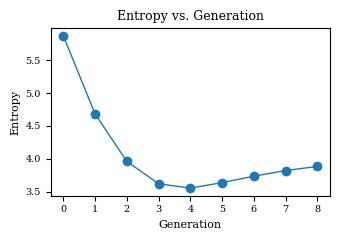

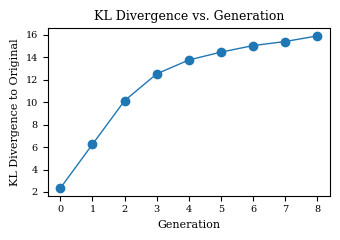

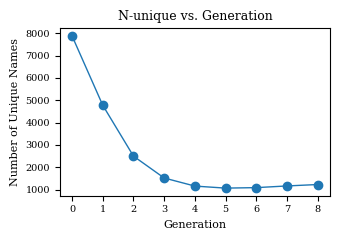

In [13]:
## Vizualisation: 
import matplotlib.pyplot as plt

# --- Load into a pandas DataFrame -------------------------------------------
df = pd.read_json("/Users/alancherman/Desktop/DATA 259/DATA_259_Project/collapse_runs/stats.json")
display(df)


# --- Publication‑style figures ------------------------------------------
pub_rc = {
    "figure.figsize": (3.5, 2.5),          # one‑column size
    "font.family": "serif",
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "lines.linewidth": 1,
    "savefig.dpi": 300,                    # high‑resolution output
}

with plt.rc_context(pub_rc):
    fig1 = plt.figure()
    plt.plot(df["generation"], df["entropy"], marker="o")
    plt.xlabel("Generation")
    plt.ylabel("Entropy")
    plt.title("Entropy vs. Generation")
    plt.tight_layout()
    plt.show()

    fig2 = plt.figure()
    plt.plot(df["generation"], df["kl_to_orig"], marker="o")
    plt.xlabel("Generation")
    plt.ylabel("KL Divergence to Original")
    plt.title("KL Divergence vs. Generation")
    plt.tight_layout()
    plt.show()

    fig3 = plt.figure()
    plt.plot(df["generation"], df["N-unique"], marker="o")
    plt.xlabel("Generation")
    plt.ylabel("Number of Unique Names")
    plt.title("N-unique vs. Generation")
    plt.tight_layout()
    plt.show()